In [2]:
from pathlib import Path
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
from zoneinfo import ZoneInfo
import matplotlib.dates as mdates

In [14]:
# load data
data_path = Path('../database/i10-broadway')
X_tensor = np.load(data_path / 'X_tensor_1h_up.npz', allow_pickle=True)['X_tensor']
X_full = pd.read_parquet(data_path / 'X_full_1h_up.parquet')

# Peek shapes/types to guide later steps
print('X_tensor type:', type(X_tensor), 'shape:', getattr(X_tensor, 'shape', None))
print('X_full   type:', type(X_full), 'shape:', getattr(X_full, 'shape', None))

X_tensor type: <class 'numpy.ndarray'> shape: (50, 2386, 8)
X_full   type: <class 'pandas.core.frame.DataFrame'> shape: (119300, 8)


In [15]:
X_full.head()

speed  travel_time_seconds  weekend  \
tmc_code  time_bin                                                             
115+04177 2025-06-16 00:00:00+00:00  70.133333             7.598167      0.0   
          2025-06-16 01:00:00+00:00  69.583333             7.665000      0.0   
          2025-06-16 02:00:00+00:00  67.300000             7.950667      0.0   
          2025-06-16 03:00:00+00:00  71.933333             7.411000      0.0   
          2025-06-16 04:00:00+00:00  71.816667             7.422000      0.0   

                                     evt_duration  evt_cat_planned  \
tmc_code  time_bin                                                   
115+04177 2025-06-16 00:00:00+00:00           0.0              0.0   
          2025-06-16 01:00:00+00:00           0.0              0.0   
          2025-06-16 02:00:00+00:00           0.0              0.0   
          2025-06-16 03:00:00+00:00           0.0              0.0   
          2025-06-16 04:00:00+00:00           0.0              0.0   

                                     evt_cat_unplanned  evt_cat_misc     miles  
tmc_code  time_bin                                                              
115+04177 2025-06-16 00:00:00+00:00                0.0           0.0  0.147902  
          2025-06-16 01:00:00+00:00                0.0           0.0  0.147902  
          2025-06-16 02:00:00+00:00                0.0           0.0  0.147902  
          2025-06-16 03:00:00+00:00                0.0           0.0  0.147902  
          2025-06-16 04:00:00+00:00                0.0           0.0  0.147902

In [16]:
# downselect to rows with any event, and balance with some no-event rows. 
# # Build any_event mask
df = X_full
events_col = ['evt_cat_planned', 'evt_cat_unplanned', 'evt_cat_misc']
vals_col = ['speed', 'travel_time_seconds', 'miles']
any_event = df[events_col].fillna(0).astype(int).sum(axis=1) > 0

# Split into events and no-events
df_w_events = df[any_event]
df_wo_events = df[~any_event]

# Balance: sample no-events to match number of event rows (1:1)
n_events = len(df_w_events)
if n_events == 0:
    raise ValueError("No event rows found; cannot balance.")
neg_sample = df_wo_events.sample(n=min(n_events, len(df_wo_events)), random_state=42)
# neg_sample = df_wo_events.sample(n=1, random_state=42)

# Combine and shuffle
df_balanced = (
    pd.concat([df_w_events, neg_sample], axis=0)
      .sample(frac=1.0, random_state=42)
)
print(f"Events: {len(df_w_events)} | No-events (sampled): {len(neg_sample)} | Total balanced: {len(df_balanced)}")
print(f"Selected {len(df_balanced) / len(df) * 100}% of full data")


Events: 877 | No-events (sampled): 877 | Total balanced: 1754
Selected 1.4702430846605197% of full data


In [17]:
df_w_events

speed  travel_time_seconds  weekend  \
tmc_code  time_bin                                                             
115+04178 2025-07-15 03:00:00+00:00  67.683333            17.744167      0.0   
          2025-07-15 04:00:00+00:00  70.916667            16.929167      0.0   
          2025-07-15 05:00:00+00:00  70.350000            17.054500      0.0   
          2025-07-15 06:00:00+00:00  69.233333            17.339833      0.0   
          2025-07-15 07:00:00+00:00  66.433333            18.083333      0.0   
...                                        ...                  ...      ...   
115P04188 2025-09-14 12:00:00+00:00  70.350000            36.302333      1.0   
          2025-09-14 13:00:00+00:00  69.566667            36.701167      1.0   
          2025-09-14 14:00:00+00:00  69.566667            36.695333      1.0   
          2025-09-14 15:00:00+00:00  68.866667            37.071167      1.0   
          2025-09-16 11:00:00+00:00  67.550000            37.841167      0.0   

                                     evt_duration  evt_cat_planned  \
tmc_code  time_bin                                                   
115+04178 2025-07-15 03:00:00+00:00           0.0              1.0   
          2025-07-15 04:00:00+00:00           0.0              1.0   
          2025-07-15 05:00:00+00:00           0.0              1.0   
          2025-07-15 06:00:00+00:00           0.0              1.0   
          2025-07-15 07:00:00+00:00           0.0              1.0   
...                                           ...              ...   
115P04188 2025-09-14 12:00:00+00:00           0.0              0.0   
          2025-09-14 13:00:00+00:00           0.0              0.0   
          2025-09-14 14:00:00+00:00           0.0              0.0   
          2025-09-14 15:00:00+00:00           0.0              0.0   
          2025-09-16 11:00:00+00:00           0.0              0.0   

                                     evt_cat_unplanned  evt_cat_misc     miles  
tmc_code  time_bin                                                              
115+04178 2025-07-15 03:00:00+00:00                0.0           0.0  0.343060  
          2025-07-15 04:00:00+00:00                0.0           0.0  0.343060  
          2025-07-15 05:00:00+00:00                0.0           0.0  0.343060  
          2025-07-15 06:00:00+00:00                0.0           0.0  0.343060  
          2025-07-15 07:00:00+00:00                0.0           0.0  0.343060  
...                                                ...           ...       ...  
115P04188 2025-09-14 12:00:00+00:00                2.0           0.0  0.708911  
          2025-09-14 13:00:00+00:00                1.0           0.0  0.708911  
          2025-09-14 14:00:00+00:00                1.0           0.0  0.708911  
          2025-09-14 15:00:00+00:00                1.0           0.0  0.708911  
          2025-09-16 11:00:00+00:00                1.0           0.0  0.708911  

[877 rows x 8 columns]

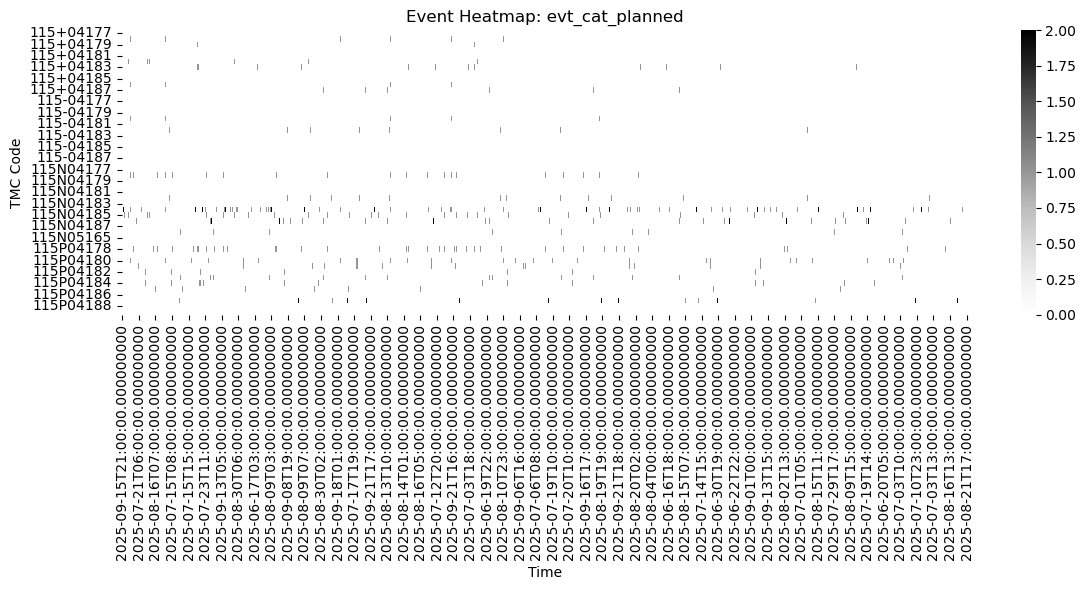

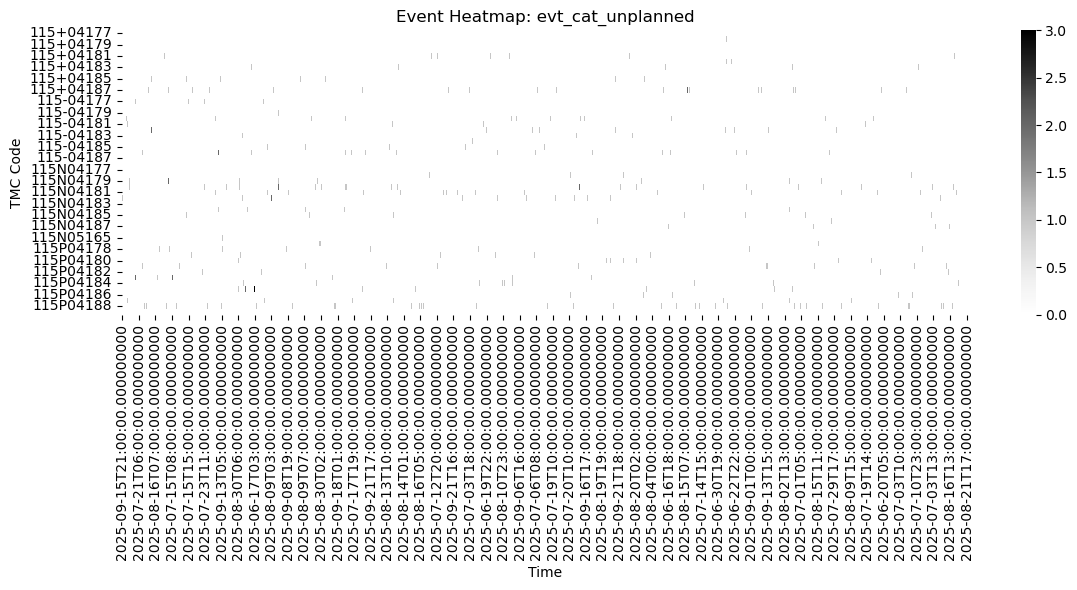

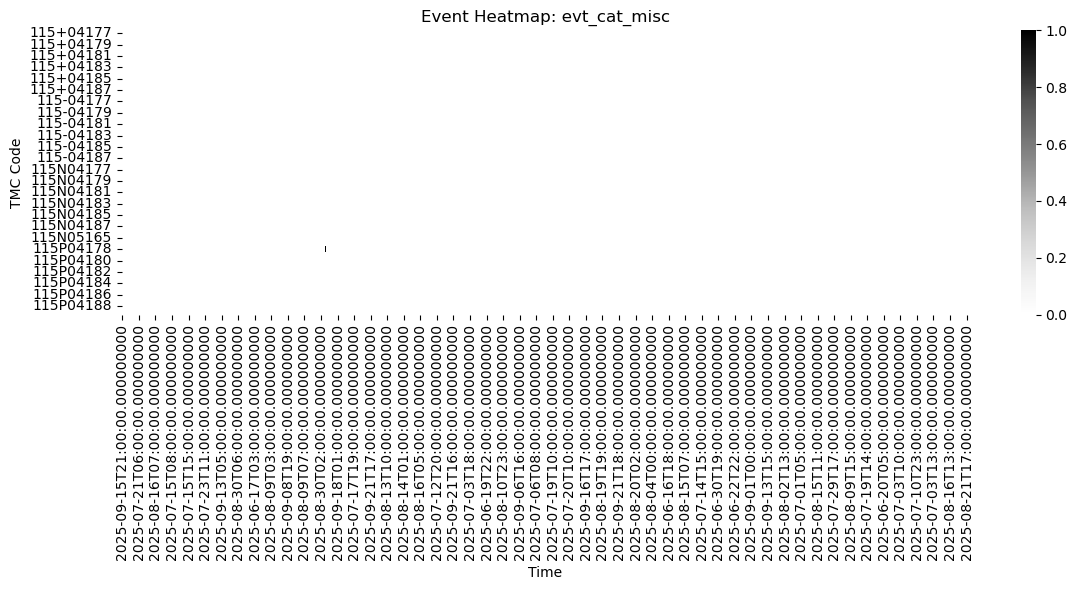

In [8]:

X_sel = df_balanced[events_col]
for col in events_col:
    data = X_sel[col].unstack(level='tmc_code').fillna(0)
    plt.figure(figsize=(12, 6))
    sns.heatmap(data.T, cmap='Greys')
    plt.title(f"Event Heatmap: {col}")
    plt.xlabel("Time")
    plt.ylabel("TMC Code")
    plt.tight_layout()
    plt.show()

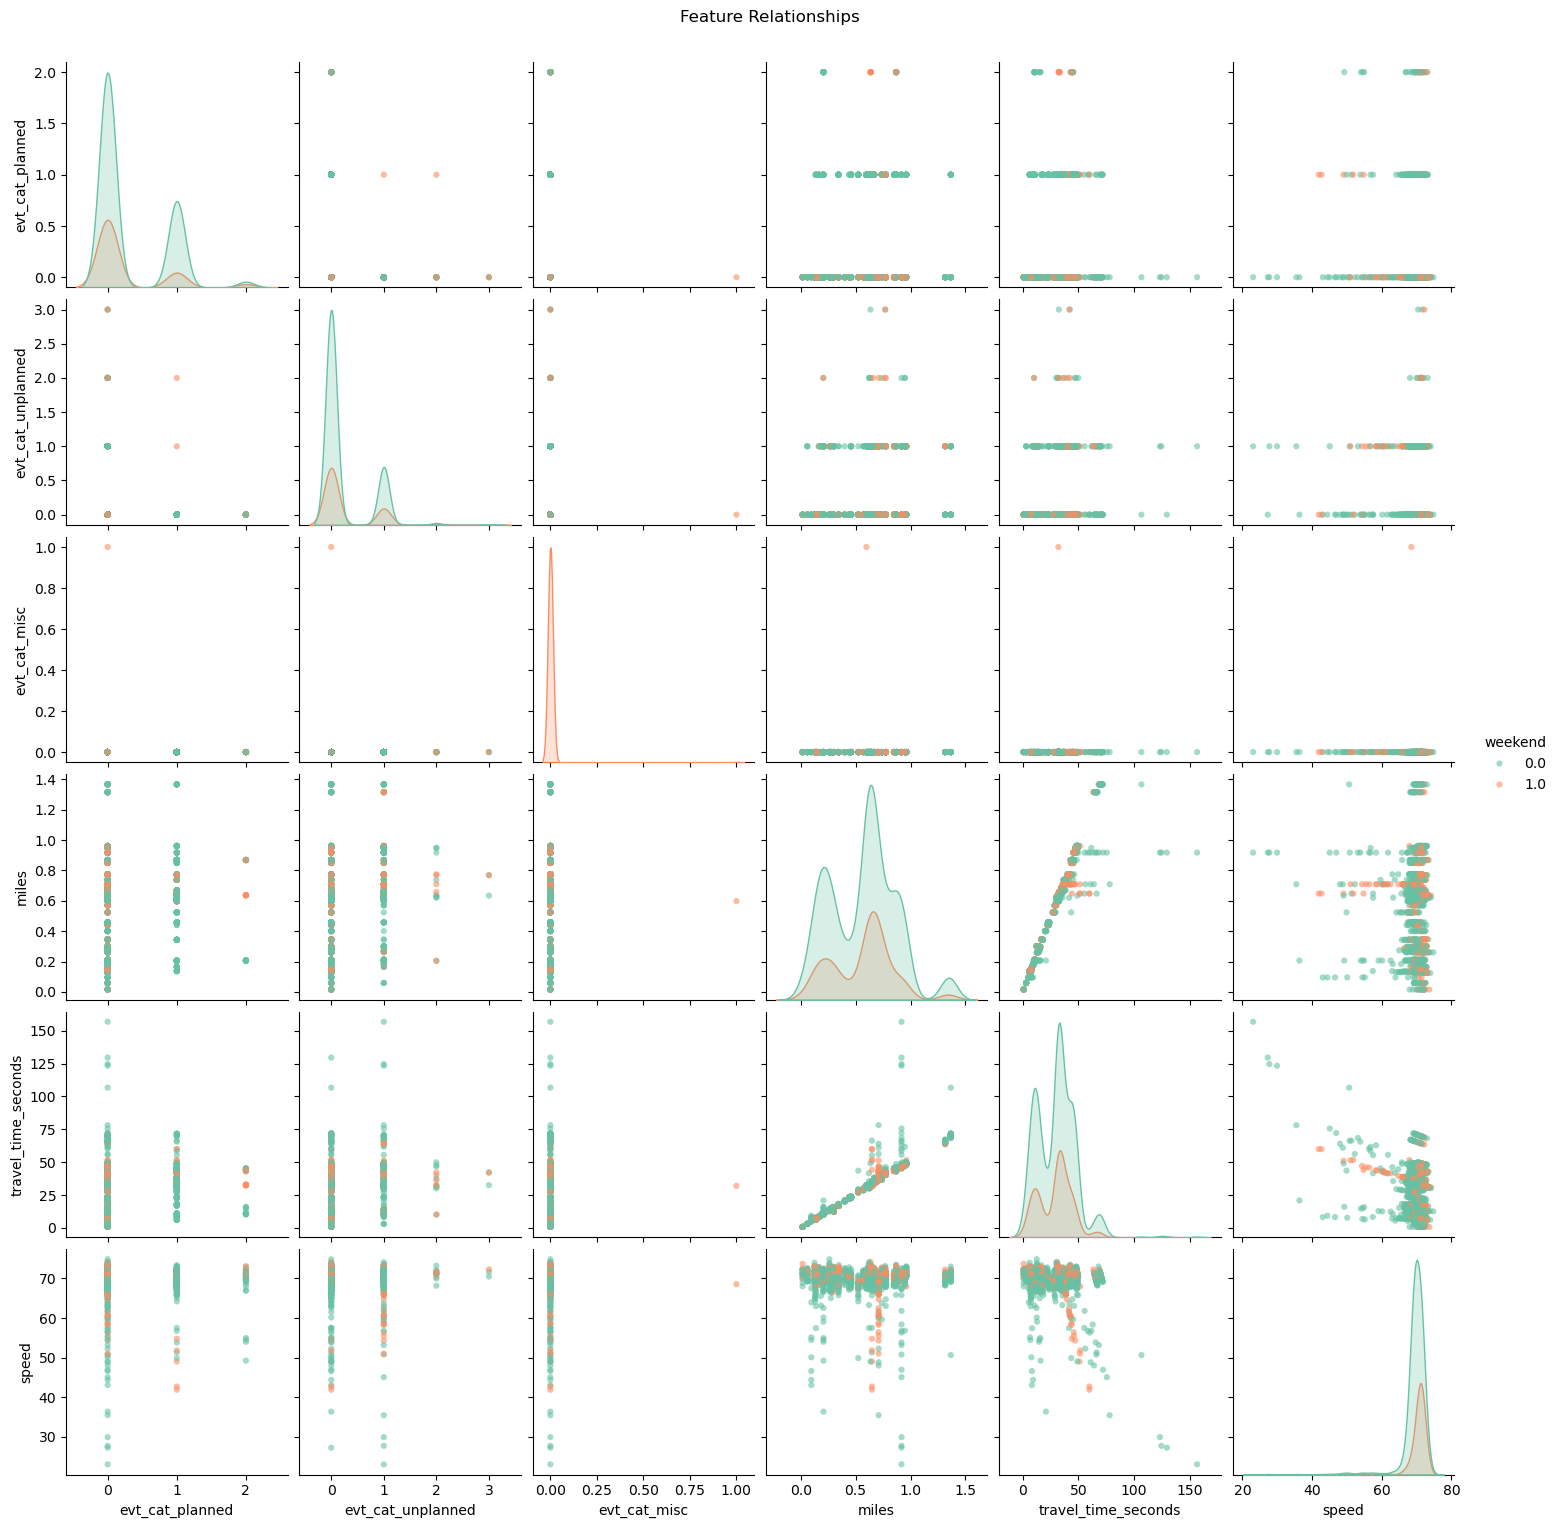

In [20]:
# use sns.pairplot to visualize the relationship between features and labels in X_full
# label
label_col = ['travel_time_seconds','speed']
feature_cols = events_col + ['miles']

sample_df = df_balanced.sample(n=min(len(df_balanced), 3000), random_state=42)  # adjust sample size
sns.pairplot(
    sample_df,
    vars=feature_cols+label_col,
    hue='weekend',
    diag_kind='kde',
    palette='Set2',
    plot_kws={'alpha': 0.6, 's': 20, 'edgecolor': 'none'}
)

plt.suptitle("Feature Relationships", y=1.02)
plt.show()

In [21]:
# "flatten data" into training data X and labels y, ignore the continuity in time and space. Treat data in each time bin and each TMC as independent samples.
label_col = ['travel_time_seconds']
feature_cols = events_col + ['miles'] + ['weekend']

df_flat = df_balanced.reset_index()

X = df_flat[feature_cols]#.copy()
y = df_flat[label_col]#.copy()

# Basic NA handling: drop rows with NA in y; impute X with median
mask_valid = X.notna().all(axis=1)
X = X[mask_valid]
y = y[mask_valid]

print("Features: ",feature_cols)
print('Feature shape:', X.shape, '| Label shape:', y.shape)

Features:  ['evt_cat_planned', 'evt_cat_unplanned', 'evt_cat_misc', 'miles', 'weekend']
Feature shape: (1754, 5) | Label shape: (1754, 1)


In [22]:
# Split the data into training and test sets with shuffle (fix random seed for reproducibility)
from sklearn.model_selection import train_test_split

# If label looks discrete with few unique values, we could treat as classification; here we'll proceed as regression.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print('Train shapes:', X_train.shape, y_train.shape)
print('Test shapes: ', X_test.shape, y_test.shape)

Train shapes: (1403, 5) (1403, 1)
Test shapes:  (351, 5) (351, 1)


In [23]:
# Train a LinearRegression model with Pipeline and StandardScaler
# Report the model cross-validation error on the training set and the test set.
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import root_mean_squared_error, r2_score

models = {
    'pipe_lr_full_evt': Pipeline([
        ('scaler', StandardScaler(with_mean=False)),  # with_mean=False is safer if any sparse-like
        ('linreg', LinearRegression())
    ]),
    'pipe_lr_no_evt': Pipeline([
        ('select', ColumnTransformer([
            ('num', StandardScaler(with_mean=False), ['miles'])
        ], remainder='drop')),  # drop everything else
        ('linreg', LinearRegression())
    ]),
    'pipe_lr_interactions': Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
        ('linreg', LinearRegression())
    ]),
    'pipe_ridge': Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(alpha=1.0))
    ])
}

for model_name, pipe in models.items():
    print(f"\nModel: {model_name}")

    # Cross-validated negative MSE on training split
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)
    print('CV RMSE (5-fold) mean:', cv_rmse.mean(), 'std:', cv_rmse.std())

    # Fit on training and evaluate on test
    pipe.fit(X_train, y_train)

    # Training metrics (on full training set)
    y_train_pred = pipe.predict(X_train)
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    # Test metrics
    y_test_pred = pipe.predict(X_test)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(' Train RMSE:', train_rmse, '| R^2:', train_r2)
    print(' Test RMSE:', test_rmse, ' | R^2:', test_r2)


Model: pipe_lr_full_evt
CV RMSE (5-fold) mean: 4.123485075201161 std: 2.040954699368279
 Train RMSE: 4.584551563818817 | R^2: 0.9201638045253469
 Test RMSE: 6.646463425571217  | R^2: 0.850567647236729

Model: pipe_lr_no_evt
CV RMSE (5-fold) mean: 4.132639339653691 std: 2.0375222829596544
 Train RMSE: 4.592659833241116 | R^2: 0.9198811571114497
 Test RMSE: 6.659564146397893  | R^2: 0.8499779799879725

Model: pipe_lr_interactions
CV RMSE (5-fold) mean: 4.116057580333066 std: 2.0281291793729364
 Train RMSE: 4.566723390035798 | R^2: 0.9207835231841035
 Test RMSE: 6.622544856424368  | R^2: 0.8516412337739382

Model: pipe_ridge
CV RMSE (5-fold) mean: 4.122630385156169 std: 2.042607048927854
 Train RMSE: 4.584565856225743 | R^2: 0.9201633067435439
 Test RMSE: 6.6466689240729195  | R^2: 0.8505584066534725


In [24]:
corr = df_balanced[['travel_time_seconds','speed','miles',
               'evt_cat_planned','evt_cat_unplanned','evt_cat_misc']].corr()
print(corr['travel_time_seconds'])
print(corr['speed'])

travel_time_seconds    1.000000
speed                 -0.286722
miles                  0.951116
evt_cat_planned        0.142718
evt_cat_unplanned      0.199741
evt_cat_misc           0.003350
Name: travel_time_seconds, dtype: float64
travel_time_seconds   -0.286722
speed                  1.000000
miles                 -0.038556
evt_cat_planned       -0.031587
evt_cat_unplanned     -0.044636
evt_cat_misc          -0.006478
Name: speed, dtype: float64
